<h1>Import modules</h1>

In [3]:
import math ; pi=math.pi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import time

In [4]:
# Import PySSC module
import PySSC

<h1>I Compute a Sij matrix : turbo mode</h1>
<h3>Sharp / top-hat redshift bins</h3>

<h4>Define boundaries (stakes) of the redshift bins</h4>

In [5]:
#zstakes = np.linspace(0.2,1.5,num=14)
zstakes = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]) #Explicitely
zmin = np.min(zstakes) ; zmax = np.max(zstakes)

<h4>Compute the matrix</h4>

In [6]:
t0 = time.clock()
Sij = PySSC.turboSij(zstakes=zstakes)  #Uses the default cosmology of the article (arXiv:1809.05437) : Planck 2013 LCDM
t1 = time.clock()
print(t1-t0)
#The computation takes ~4 seconds on an i7 laptop

4.041803


In [7]:
# If you want to change cosmology, specify the parameters with a dictionnary in the format of CLASS :
params = {'omega_b':0.022,'omega_cdm':0.12,'H0':67.,'n_s':0.96,'sigma8':0.81}
Sijbis = PySSC.turboSij(zstakes=zstakes,cosmo_params=params)

<h1>Applications</h1>

<h3>Example 1: Plot the Sij matrix</h3>

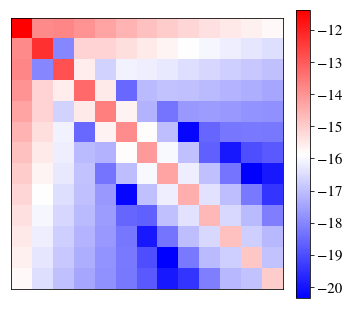

In [8]:
# Sij can be negative (anti-correlation between bins), and varies by some order of magnitude due to redshift evolution.
# Let's first plot ln|Sij|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sij)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

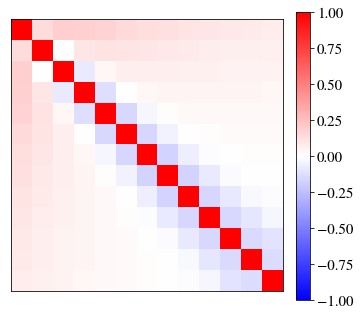

In [9]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
nzbins = len(zstakes) - 1
correl = np.zeros((nzbins,nzbins))
for i in range(nzbins):
    for j in range(nzbins):
        correl[i,j] = Sij[i,j] / np.sqrt(Sij[i,i]*Sij[j,j])
#Plot it
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

<h3>Example 2: Find the characteristic multipole ell_SSC depending on redshift</h3>

In [10]:
# The multipole where the SSC decreases the S/N by a factor 2 compared to the Gaussian cosmic variance-limited case
# Defined in Eq.46 of the article (arXiv:1809.05437)
#Compute it
fsky    = 1.
Nprobes = 1.
Resp    = 5.
ell_SSC = np.zeros(nzbins)
for i in range(nzbins):
    ell_SSC[i] = np.sqrt(2./(Nprobes*Resp**2*fsky*Sij[i,i]))

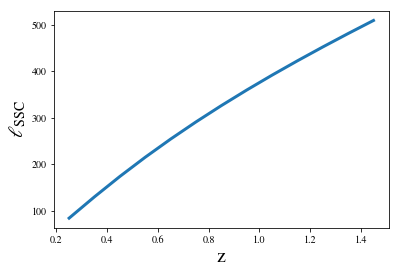

In [11]:
# Plot it as a function of redshift
zcenter = (zstakes[1:]+zstakes[:-1])/2.
plt.plot(zcenter,ell_SSC,lw=3)
plt.xlabel('z',fontsize=20) ; plt.ylabel(r'$\ell_\mathrm{SSC}$',fontsize=20)
plt.show()

so SSC starts to dominate for multipoles above a few hundred, i.e. sub-degree scale in real space

<h3>Example 3: Find the critical density of clusters where SSC/sample variance surpasses shot-noise/Poisson</h3>

In [12]:
# If Ncl is the cluster count (per steradian), then the shot-noise/Poisson variance is Cov_shot(Ncl)=Ncl/4pi
# and the SSC/sample variance is Cov_SSC = b^2 Ncl^2 * Sij
# the latter dominates shot-noise when Ncl >= Ncrit = 1./(4pi*b^2*Sij)

#Compute Ncrit
bcl = 5.                                  # Average cluster bias
Ncrit = np.zeros(nzbins)                  # Number density per sterad
for i in range(nzbins):
    Ncrit[i] = 1./(4.*pi*bcl**2*Sij[i,i])
Ncrit_deg2 = Ncrit * (pi/180.)**2         # Number density per deg^2

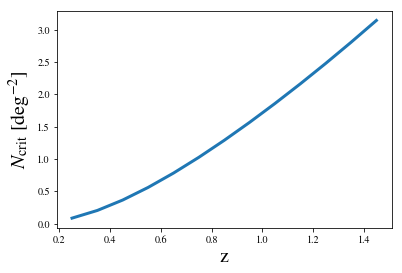

In [13]:
# Plot it as a function of redshift
plt.plot(zcenter,Ncrit_deg2,lw=3)
plt.xlabel('z',fontsize=20) ; plt.ylabel(r'$N_\mathrm{crit}$ [deg$^{-2}$]',fontsize=20)
#plt.savefig("Ncrit-halos-vs-z.png",bbox_inches='tight')
plt.show()

so SSC dominates when we detect more than a few clusters per square degree

<h1>II Compute a Sij matrix : general mode</h1>
<h2>With window functions</h2>

In [14]:
# Define redshift range
nz       = 500
z_arr    = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0

<h2>Top-hat window functions, for comparison with turbo mode</h2>

In [15]:
nbins_T   = len(zstakes)-1
windows_T = np.zeros((nbins_T,nz))
for i in range(nbins_T):
    zminbin = zstakes[i] ; zmaxbin = zstakes[i+1] ; Dz = zmaxbin-zminbin
    for iz in range(nz):
        z = z_arr[iz]
        if ((z>zminbin) and (z<=zmaxbin)):
            windows_T[i,iz] = 1/Dz

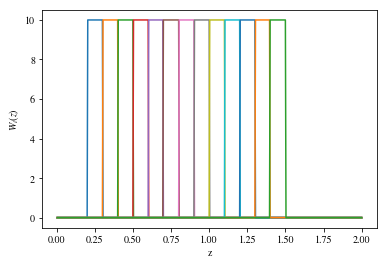

In [16]:
for i in range(nbins_T):   
    plt.plot(z_arr,windows_T[i,:])
plt.xlabel('z') ; plt.ylabel('$W_i(z)$')
plt.show()

<h4>Compute the matrices</h4>

In [17]:
# There are two different routines, which perform the k and z integrals in different orders
# We compute both of them for speed test and further comparison
t0 = time.clock()
Sijw_T = PySSC.Sij(z_arr,windows_T)
t1 = time.clock()
Sijw_T_alt = PySSC.Sij_alt(z_arr,windows_T)
t2 = time.clock()
print(t1-t0,t2-t1)

(5.22481, 13.449793)


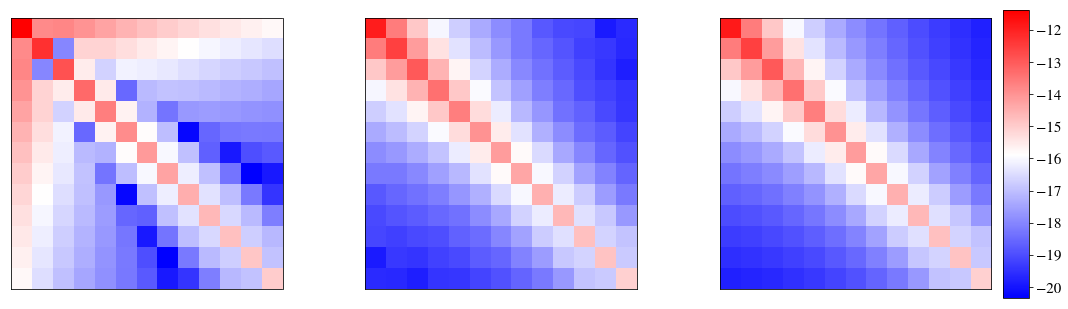

In [18]:
# Comparison with turbo mode
# Let's first plot ln|Sij| with a common range of color
lnSij = np.log(abs(Sij)) ; lnSijw_T = np.log(abs(Sijw_T))
vmin = min(lnSij.min(),lnSijw_T.min()) ; vmax = max(lnSij.max(),lnSijw_T.max()) #common range of color
# Turbo mode
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(np.log(abs(Sij)),interpolation='none',cmap='bwr',vmin=vmin,vmax=vmax,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
# General mode
plt.subplot(1,3,2)
plt.imshow(np.log(abs(Sijw_T)),interpolation='none',cmap='bwr',vmin=vmin,vmax=vmax,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
# General mode : alt
plt.subplot(1,3,3)
P = plt.imshow(np.log(abs(Sijw_T_alt)),interpolation='none',cmap='bwr',vmin=vmin,vmax=vmax,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

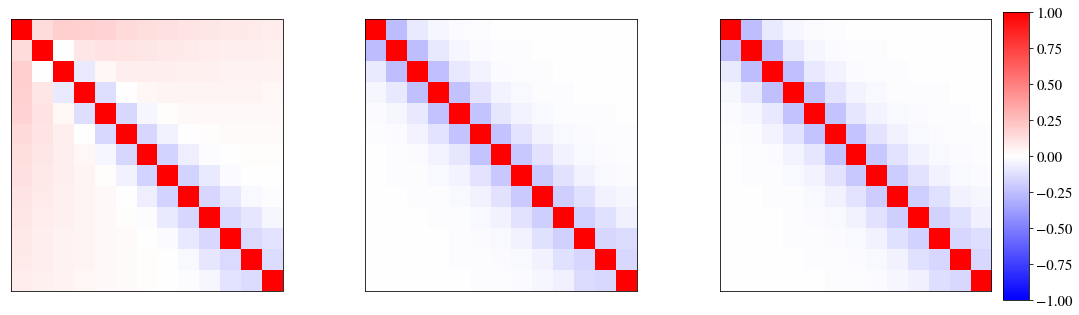

(0.1378016729371035, -0.25790565242174196, -0.25519574753879104)


In [19]:
# Let's now plot the correlation matrix : Sij/sqrt(Sii*Sjj)
#Compute the correlation matrix
correl_T = np.zeros((nbins_T,nbins_T)) ; correl_T_alt = np.zeros((nbins_T,nbins_T))
for i in range(nbins_T):
    for j in range(nbins_T):
        correl_T[i,j] = Sijw_T[i,j] / np.sqrt(Sijw_T[i,i]*Sijw_T[j,j])
        correl_T_alt[i,j] = Sijw_T_alt[i,j] / np.sqrt(Sijw_T_alt[i,i]*Sijw_T_alt[j,j])
#Plot correlation matrices
#Turbo mode
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(correl,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
#General mode
plt.subplot(1,3,2)
plt.imshow(correl_T,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
#General mode : alt
plt.subplot(1,3,3)
P = plt.imshow(correl_T_alt,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correl[0,1],correl_T[0,1],correl_T_alt[0,1])

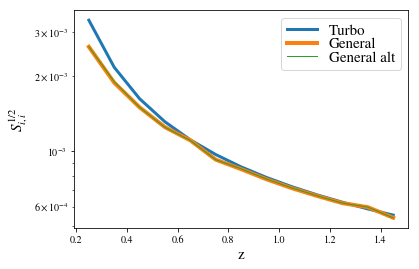

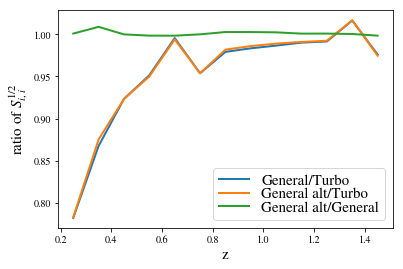

In [20]:
#Now focus on the diagonal Sii
indices = range(nbins_T)
plt.semilogy(zcenter,np.sqrt(Sij[indices,indices]),linewidth=3,label='Turbo')
plt.semilogy(zcenter,np.sqrt(Sijw_T[indices,indices]),linewidth=4,label='General')
plt.semilogy(zcenter,np.sqrt(Sijw_T_alt[indices,indices]),linewidth=1,label='General alt')
plt.legend(labelspacing=0.0,fontsize=15,loc='upper right')
plt.xlabel('z',fontsize=15)
plt.ylabel('$S_{i,i}^{1/2}$',fontsize=15)
plt.show()
#Ratios
plt.plot(zcenter,np.sqrt(Sijw_T[indices,indices]/Sij[indices,indices]),linewidth=2,label='General/Turbo')
plt.plot(zcenter,np.sqrt(Sijw_T_alt[indices,indices]/Sij[indices,indices]),linewidth=2,label='General alt/Turbo')
plt.plot(zcenter,np.sqrt(Sijw_T_alt[indices,indices]/Sijw_T[indices,indices]),linewidth=2,label='General alt/General')
plt.legend(labelspacing=0.0,fontsize=15,loc='lower right')
plt.xlabel('z',fontsize=15)
plt.ylabel('ratio of $S_{i,i}^{1/2}$',fontsize=15)
plt.show()

<h5>Conclusion:</h5> turbo mode is ok for the diagonal Sii at z>0.5, but precision decreases at lower redshifts, and it gradually fails for off-diagonal terms when the bin separation increases.
<br>This happens because turboSij assumes that the growth function varies slowly with redshift within the bin, which fails at low z.

<h2>Gaussian window functions</h2>

In [21]:
sigmaz    = 0.05
zcenter_G = [0.4,0.55,0.7,0.85,1.,1.15,1.3,1.45,1.6]
nbins_G   = len(zcenter_G)
windows_G = np.zeros((nbins_G,nz))
for i in range(nbins_G):
    windows_G[i,:] = np.exp(-(z_arr-zcenter_G[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

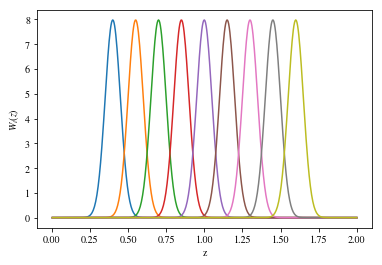

In [22]:
# Plot window functions
for i in range(nbins_G):
    plt.plot(z_arr,windows_G[i,:])
plt.xlabel('z') ; plt.ylabel('$W_i(z)$')
plt.show()

<h4>Compute the matrix</h4>

In [23]:
t0 = time.clock()
Sijw_G = PySSC.Sij(z_arr,windows_G)
t1 = time.clock()
print(t1-t0)

5.143056


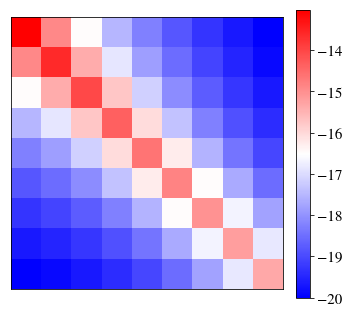

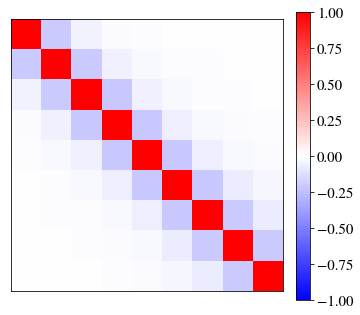

-0.20604273786722885


In [24]:
#First plot ln|Sij|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sijw_G)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
#Second plot the correlation matrix
correl_G = np.zeros((nbins_G,nbins_G))
for i in range(nbins_G):
    for j in range(nbins_G):
        correl_G[i,j] = Sijw_G[i,j] / np.sqrt(Sijw_G[i,i]*Sijw_G[j,j])
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl_G,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print correl_G[0,1]

Even though the bins overlap, there is still a significant (20%) anticorrelation between neighbouring bins

<h2>Most general case with cross-spectra : Sijkl</h2>

In [25]:
#Top-hat window functions have no interest here, since the cross-spectra would be basically zero
#So we go for Gaussian window functions
t0 = time.clock()
Sijkl_G = PySSC.Sijkl(z_arr,windows_G)
t1 = time.clock()
print(t1-t0)

5.783268


In [26]:
#Build indexing of pairs of redshift bins
npairs_G = (nbins_G*(nbins_G+1))//2
pairs_G  = np.zeros((2,npairs_G),dtype=int)
count       = 0
for ibin in range(nbins_G):
    for jbin in range(ibin,nbins_G):
        pairs_G[0,count] = ibin
        pairs_G[1,count] = jbin
        count +=1
#Recast Sijkl as a matrix of pairs, for later visualisation
Sijkl_G_recast = np.zeros((npairs_G,npairs_G))
for ipair in range(npairs_G):
    ibin = pairs_G[0,ipair]
    jbin = pairs_G[1,ipair]
    for jpair in range(npairs_G):
        kbin = pairs_G[0,jpair]
        lbin = pairs_G[1,jpair]
        Sijkl_G_recast[ipair,jpair] = Sijkl_G[ibin,jbin,kbin,lbin]

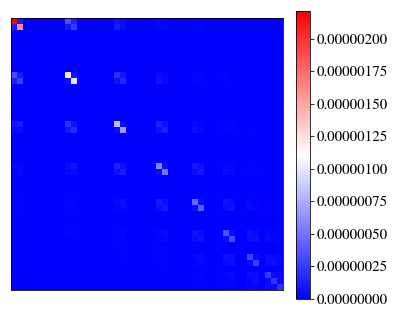

In [27]:
#Plot |Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(abs(Sijkl_G_recast),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()

Many elements are zero : indeed bins far enough apart have basically no overlap so the cross-spectra is zero
<br>If the overlap is small enough (&lt;0.1% by default), the code sets Sijkl to zero

In [28]:
#Remove pairs of bins with zero covariance
invalid_list         = np.where(np.diag(Sijkl_G_recast)==0)[0]
Sijkl_G_recast_valid = np.delete(np.delete(Sijkl_G_recast,invalid_list,0),invalid_list,1)
nvalid               = Sijkl_G_recast_valid.shape[0]

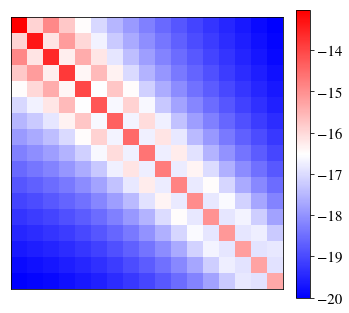

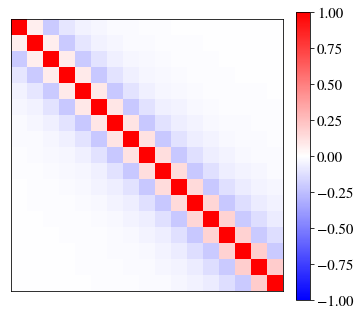

-0.21448680112044952


In [29]:
#Plot ln|Sijkl|
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(np.log(abs(Sijkl_G_recast_valid)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin])
P.axes.tick_params(labelsize=15)
plt.xticks([]) ; plt.yticks([])
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
#Second plot the correlation matrix
correl_ijkl_G = np.zeros((nvalid,nvalid))
for i in range(nvalid):
    for j in range(nvalid):
        correl_ijkl_G[i,j] = Sijkl_G_recast_valid[i,j] / np.sqrt(Sijkl_G_recast_valid[i,i]*Sijkl_G_recast_valid[j,j])
fig = plt.figure(figsize=(5.5,5))
P = plt.imshow(correl_ijkl_G,interpolation='none',cmap='bwr',vmin=-1,vmax=1,extent=[zmin,zmax,zmax,zmin])
plt.xticks([]) ; plt.yticks([])
P.axes.tick_params(labelsize=15)
ax1 = fig.add_axes([0.89, 0.1, 0.035, 0.8])
cbar = plt.colorbar(P,ax1)
cbar.ax.tick_params(labelsize=15)
plt.show()
print(correl_ijkl_G.min())

The off-diagonal structure is quite important, there is positive correlation between closest cross-spectra, but also non-negligible anti-correlation with the second-closest cross-spectrum

<h2>Advanced: use your own cosmology</h2>

Say you do not want PySSC to recompute (with CLASS) the cosmology : comoving distances, P(k) etc.
<br>For instance because you have already computed it, or you study a non-standard model that is not supported by CLASS.
<br>Then you can input this cosmology to PySSC by creating an object with the same keys as the CLASS objects, and pass it to PySSC routines.
<br>In detail, if the object is called cosmo, the necessary keys are:
<ul><li>cosmo.h giving the hubble factor</li>
    <li>cosmo.z_of_r giving the comoving distance (in Mpc) and its derivative w.r.t. redshift</li>
    <li>cosmo.pk(k,z) giving the (linear) matter power spectrum in Mpc^3</li>
    <li>cosmo.scale_independent_growth_factor(z) giving the linear growth factor</li>
</ul>
The format of these objects should be identical to the one of CLASS.

<h5>Example:
<br>let's precompute the cosmo with CLASS ourselves and feed it to PySSC</h5>

In [30]:
from classy import Class

In [31]:
#Precompute the cosmo
cosmo = Class()
dico4Class = params
dico4Class['output'] = 'mPk'
cosmo.set(dico4Class)
cosmo.compute()

In [32]:
#Feed it to PySSC: use the optional parameter cosmo_Class
t0 = time.clock()
Sij_precomp = PySSC.Sij(z_arr,windows_G,cosmo_Class=cosmo)
t1 = time.clock()
print(t1-t0)

0.955822


In [33]:
#Compute the same matrix the standard way
t0 = time.clock()
Sij_std = PySSC.Sij(z_arr,windows_G,cosmo_params=params)
t1 = time.clock()
print(t1-t0)

5.027398


In [34]:
#Check the difference
diff = Sij_precomp - Sij_std
print(diff.min(),diff.max())

(0.0, 0.0)
